In [1]:
import sys
import pandas as pd
import time as time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.lines import Line2D
import numba
import scienceplots
plt.style.use('science')

# Load data

In [2]:
# Main detectors
dssd = pd.read_csv('processed_data/dssd_non_vetoed_events.csv') # non-vetoed, calibrated dssd events 
ppac = pd.read_csv('processed_data/ppac_events.csv') # raw, uncalibrated
ruth = pd.read_csv('processed_data/rutherford_events.csv')

# DSSD regions
imp = dssd[dssd['event_type'] == 'imp']
boxE = dssd[dssd['event_type'] == 'boxE']
boxW = dssd[dssd['event_type'] == 'boxW']
boxT = dssd[dssd['event_type'] == 'boxT']
boxB = dssd[dssd['event_type'] == 'boxB']

# PPAC 
cathode = ppac[ppac['detector'] == 'cathode']
anodeV = ppac[ppac['detector'] == 'anodeV']
anodeH = ppac[ppac['detector'] == 'anodeH']

# Rutherfords
ruth_E = ruth[ruth['detector'] == 'ruthE']
ruth_W = ruth[ruth['detector'] == 'ruthW']

# PPAC-SHREC coincidences

In [3]:
# Coincidence window
window_before_ns = 5000  # 2000 ns (2 us) before
window_after_ns = 5000   # 1000 ns (1 us) after

# Convert to picoseconds for use with timetag values
window_before_ps = window_before_ns * 1000  # ns to ps
window_after_ps = window_after_ns * 1000    # ns to ps

In [4]:
# Sort dfs by time (should already be sorted)
cathode_sorted = cathode.sort_values('timetag').reset_index(drop=True)
anodeV_sorted = anodeV.sort_values('timetag').reset_index(drop=True)
anodeH_sorted = anodeH.sort_values('timetag').reset_index(drop=True)
imp_sorted = imp.sort_values('tagx').reset_index(drop=True)  # Using tagx for IMP

In [5]:
# Grab timetag vals (faster searching)
cathode_timetags = cathode_sorted['timetag'].values
anodeV_timetags = anodeV_sorted['timetag'].values
anodeH_timetags = anodeH_sorted['timetag'].values
imp_timetags = imp_sorted['tagx'].values  # Using tagx as the IMP timetag

In [6]:
# Function to find PPAC events within the time window
def find_events_in_window(imp_timetag, detector_timetags, window_before_ps, window_after_ps):
    """
    Find ppac events that occur within the specified time window around the IMP event.
    All time values are in picoseconds.
    
    Params:
    -----------
    imp_timetag : Timestamp of the IMP event in picoseconds
    detector_timetags : Array of detector timestamps in picoseconds
    window_before_ps : Time window before the IMP event in picoseconds
    window_after_ps : Time window after the IMP event in picoseconds
        
    Returns:
    --------
    Indices of events within the window
    """
    # Calculate the time bounds
    lower_bound = imp_timetag - window_before_ps  # Time window before IMP
    upper_bound = imp_timetag + window_after_ps   # Time window after IMP
    
    # Find all events within these bounds using binary search 
    lower_idx = np.searchsorted(detector_timetags, lower_bound)
    upper_idx = np.searchsorted(detector_timetags, upper_bound)
    
    if upper_idx > lower_idx:
        return list(range(lower_idx, upper_idx))
    return []

# Start timing the search
start_time = time.time()

# Create list to store coincident events
coincident_events = []
non_ppac_coincident_events = []

# Number of IMP events to process
total_imp_events = len(imp_sorted)
print(f"Processing {total_imp_events} IMP events...")

# For each IMP event, find coincident PPAC signals
for idx, imp_row in imp_sorted.iterrows():
    imp_timetag = imp_row['tagx'] # remember we are using tagx for the timetag here
    
    # Find ppac events in time window
    cathode_indices = find_events_in_window(imp_timetag, cathode_timetags, window_before_ps, window_after_ps)
    anodeV_indices = find_events_in_window(imp_timetag, anodeV_timetags, window_before_ps, window_after_ps)
    anodeH_indices = find_events_in_window(imp_timetag, anodeH_timetags, window_before_ps, window_after_ps)
    
    # Only proceed if we have coincidences in all three PPAC detectors - AND condition here
    if cathode_indices and anodeV_indices and anodeH_indices:
        
        # Find the closest event in each detector (smallest absolute time difference)
        cathode_diffs = np.abs(cathode_timetags[cathode_indices] - imp_timetag)
        anodeV_diffs = np.abs(anodeV_timetags[anodeV_indices] - imp_timetag)
        anodeH_diffs = np.abs(anodeH_timetags[anodeH_indices] - imp_timetag)
        
        closest_cathode_idx = cathode_indices[np.argmin(cathode_diffs)]
        closest_anodeV_idx = anodeV_indices[np.argmin(anodeV_diffs)]
        closest_anodeH_idx = anodeH_indices[np.argmin(anodeH_diffs)]
        
        # Get the corresponding rows
        cathode_data = cathode_sorted.iloc[closest_cathode_idx]
        anodeV_data = anodeV_sorted.iloc[closest_anodeV_idx]
        anodeH_data = anodeH_sorted.iloc[closest_anodeH_idx]
        
        # Calculate time difference values (in picoseconds)
        # +ve = PPAC after IMP, -ve = PPAC before IMP
        dt_cathode_ps = cathode_data['timetag'] - imp_timetag
        dt_anodeV_ps = anodeV_data['timetag'] - imp_timetag
        dt_anodeH_ps = anodeH_data['timetag'] - imp_timetag
        
        # Create event data dictionary with all relevant information
        event_data = {
            # IMP data
            'imp_timetag': imp_timetag,
            'imp_x': imp_row['x'],
            'imp_y': imp_row['y'],
            'imp_tagx': imp_row['tagx'],
            'imp_tagy': imp_row['tagy'],
            'imp_nfile': imp_row['nfile'],
            'imp_tdelta': imp_row['tdelta'],
            'imp_nX': imp_row['nX'],
            'imp_nY': imp_row['nY'],
            'imp_xE': imp_row['xE'],
            'imp_yE': imp_row['yE'],
            'xboard': imp_row['xboard'],
            'yboard': imp_row['yboard'],
            
            # Cathode data
            'cathode_timetag': cathode_data['timetag'],
            'cathode_energy': cathode_data['energy'],
            'cathode_board': cathode_data['board'],
            'cathode_channel': cathode_data['channel'],
            'cathode_nfile': cathode_data['nfile'],
            
            # AnodeV data
            'anodeV_timetag': anodeV_data['timetag'],
            'anodeV_energy': anodeV_data['energy'],
            'anodeV_board': anodeV_data['board'],
            'anodeV_channel': anodeV_data['channel'],
            'anodeV_nfile': anodeV_data['nfile'],
            
            # AnodeH data
            'anodeH_timetag': anodeH_data['timetag'],
            'anodeH_energy': anodeH_data['energy'],
            'anodeH_board': anodeH_data['board'],
            'anodeH_channel': anodeH_data['channel'],
            'anodeH_nfile': anodeH_data['nfile'],
            
            # Time difference values (in picoseconds)
            'dt_cathode_ps': dt_cathode_ps,
            'dt_anodeV_ps': dt_anodeV_ps,
            'dt_anodeH_ps': dt_anodeH_ps,
            
            # Convert to nanoseconds for convenience
            'dt_cathode_ns': dt_cathode_ps / 1000,
            'dt_anodeV_ns': dt_anodeV_ps / 1000,
            'dt_anodeH_ns': dt_anodeH_ps / 1000
        }
        
        coincident_events.append(event_data)
    else:
        non_coincident_data = {
            # IMP data
            'dec_timetag': imp_timetag,
            'dec_x': imp_row['x'],
            'dec_y': imp_row['y'],
            'dec_tagx': imp_row['tagx'],
            'dec_tagy': imp_row['tagy'],
            'dec_nfile': imp_row['nfile'],
            'dec_tdelta': imp_row['tdelta'],
            'dec_nX': imp_row['nX'],
            'dec_nY': imp_row['nY'],
            'dec_xE': imp_row['xE'],
            'dec_yE': imp_row['yE'],
            'xboard': imp_row['xboard'],
            'yboard': imp_row['yboard'],
        }
        
        non_ppac_coincident_events.append(non_coincident_data)
        
        # TODO - Since we use an AND condition between the ppac plates, we need to add a condition in to
        #        make sure theres no signal at all.
    
    # Print progress every 10,000 events
    if idx % 10000 == 0 and idx > 0:
        elapsed = time.time() - start_time
        events_per_sec = idx / elapsed
        remaining_time = (total_imp_events - idx) / events_per_sec if events_per_sec > 0 else 0
        print(f"Processed {idx}/{total_imp_events} events ({idx/total_imp_events*100:.1f}%) - Rate: {events_per_sec:.1f} events/sec - ETA: {remaining_time:.1f} sec")

# Create the df with coincident events
coincident_imp = pd.DataFrame(coincident_events)
print(f"Found {len(coincident_imp)} coincidences within the window")

# Calculate total processing time
elapsed_time = time.time() - start_time
print(f"Total processing time: {elapsed_time:.2f} seconds")
print(f"Processing rate: {total_imp_events/elapsed_time:.1f} events/second")



Processing 513316 IMP events...
Processed 10000/513316 events (1.9%) - Rate: 7816.4 events/sec - ETA: 64.4 sec
Processed 20000/513316 events (3.9%) - Rate: 8244.8 events/sec - ETA: 59.8 sec
Processed 30000/513316 events (5.8%) - Rate: 8547.6 events/sec - ETA: 56.5 sec
Processed 40000/513316 events (7.8%) - Rate: 8750.7 events/sec - ETA: 54.1 sec
Processed 50000/513316 events (9.7%) - Rate: 8870.3 events/sec - ETA: 52.2 sec
Processed 60000/513316 events (11.7%) - Rate: 8959.8 events/sec - ETA: 50.6 sec
Processed 70000/513316 events (13.6%) - Rate: 9008.2 events/sec - ETA: 49.2 sec
Processed 80000/513316 events (15.6%) - Rate: 9032.2 events/sec - ETA: 48.0 sec
Processed 90000/513316 events (17.5%) - Rate: 9064.9 events/sec - ETA: 46.7 sec
Processed 100000/513316 events (19.5%) - Rate: 9090.1 events/sec - ETA: 45.5 sec
Processed 110000/513316 events (21.4%) - Rate: 9118.1 events/sec - ETA: 44.2 sec
Processed 120000/513316 events (23.4%) - Rate: 9132.2 events/sec - ETA: 43.1 sec
Processed 

# Plot raw etof

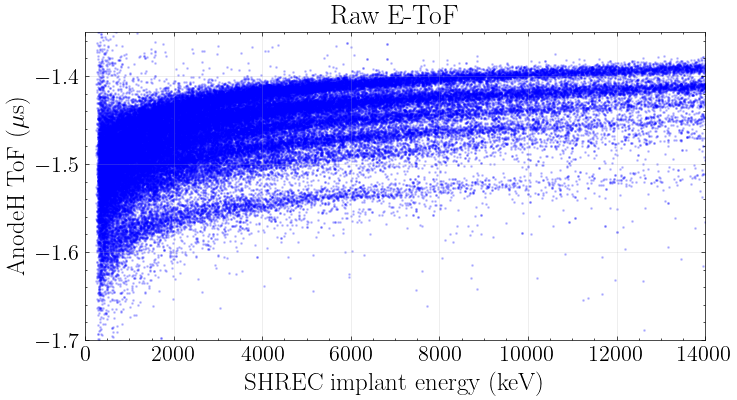

In [7]:
if not coincident_imp.empty:
    # Convert ns time differences to us for plotting
    coincident_imp['dt_cathode_us'] = coincident_imp['dt_cathode_ns'] / 1000  # ns to μs
    coincident_imp['dt_anodeV_us'] = coincident_imp['dt_anodeV_ns'] / 1000    # ns to μs
    coincident_imp['dt_anodeH_us'] = coincident_imp['dt_anodeH_ns'] / 1000    # ns to μs
    
    plt.figure(figsize=(8, 4))
    fs = 18
    plt.scatter(coincident_imp['imp_xE'], coincident_imp['dt_anodeH_us'], 
                alpha=0.2, s=1, c='blue')
    plt.xlabel("SHREC implant energy (keV)", fontsize=fs)
    plt.ylabel(r"AnodeH ToF ($\mu$s)", fontsize=fs)
    plt.title("Raw E-ToF", fontsize=fs+2)
    plt.xlim(0, 14000)
    plt.ylim(-1.7, -1.35)
    plt.grid(True, alpha=0.3)
    ax = plt.gca()
    ax.tick_params(axis='both', which='major', labelsize=fs-2)
#     plt.legend(fontsize=fs-4, frameon=True)
    plt.savefig("plots/raw_etof.pdf", dpi=1000)
else:
    print("No coincidences")

# Time correction for SHREC imp region boards

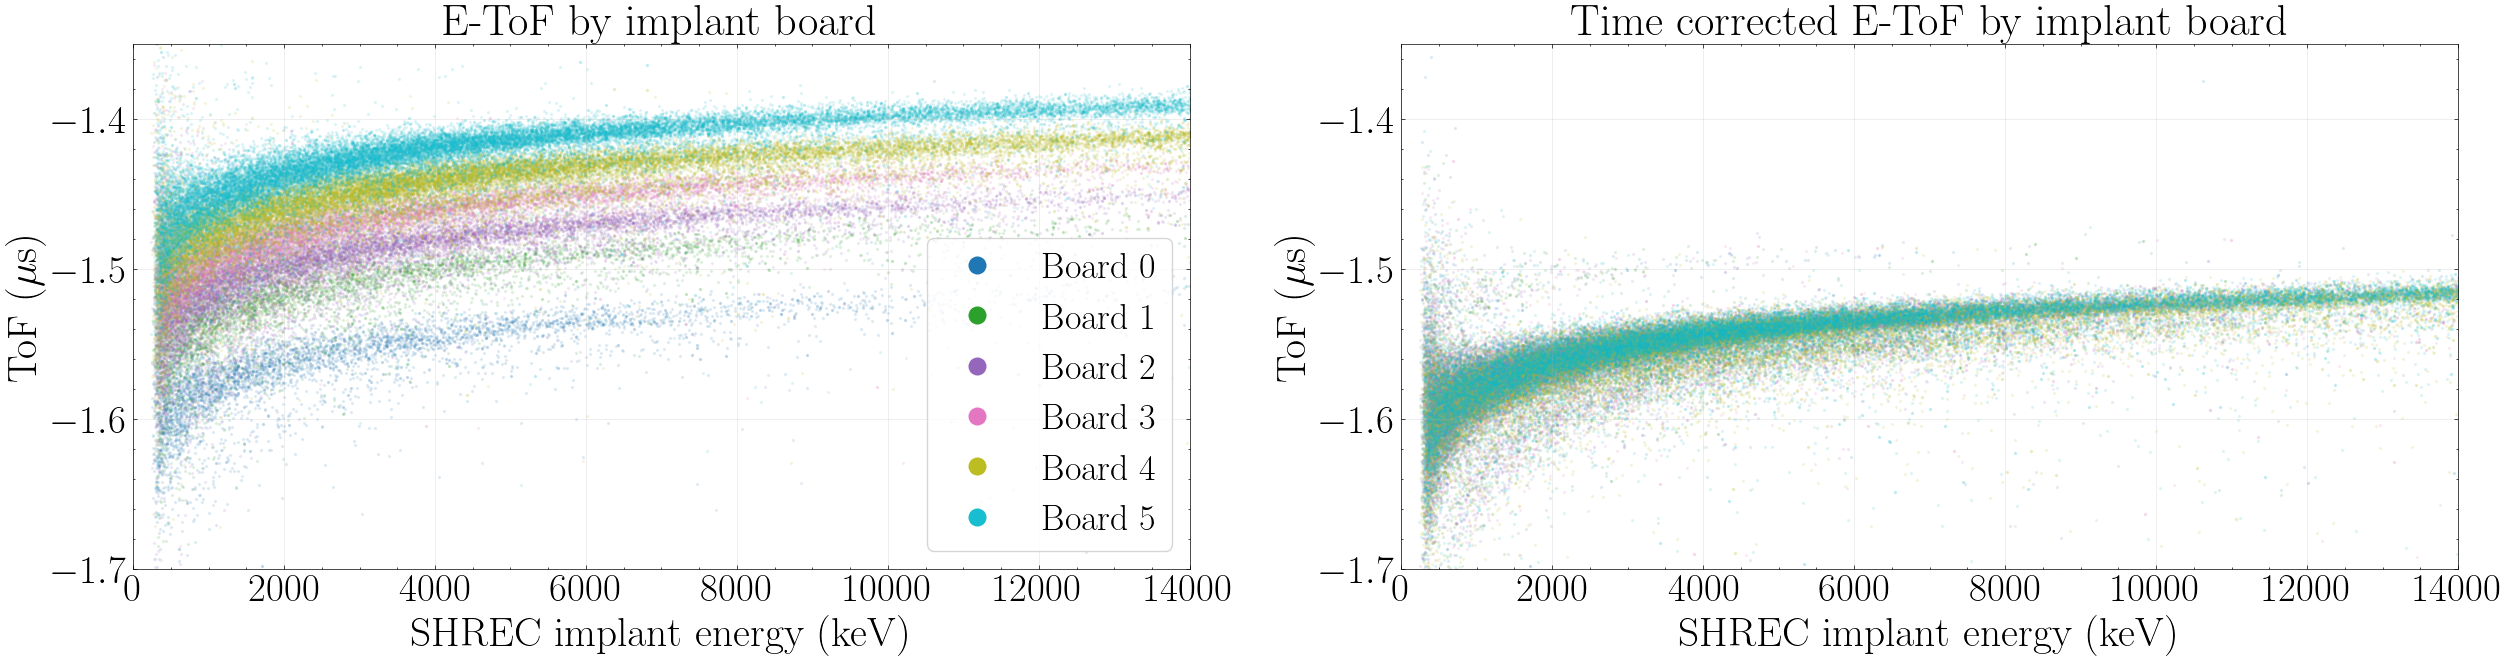

In [8]:
from matplotlib.lines import Line2D

# Get the recoil time in seconds
coincident_imp['t'] = coincident_imp['imp_timetag'] * 1e-12

# Define manual time offsets for the boards- board0 is master
manual_offsets = {
    0: 0,
    1: -0.045e-6,
    2: -0.065e-6,
    3: -0.085e-6,
    4: -0.105e-6,
    5: -0.125e-6,
}

# Calculate the corrected dt for the ppac plates in microseconds
# Staying consistent with xboard
coincident_imp['dt_anodeH_us_corr'] = coincident_imp.apply(
    lambda row: row['dt_anodeH_us'] + manual_offsets.get(row['xboard'], 0) * 1e6,
    axis=1
)

coincident_imp['dt_anodeV_us_corr'] = coincident_imp.apply(
    lambda row: row['dt_anodeV_us'] + manual_offsets.get(row['xboard'], 0) * 1e6,
    axis=1
)

coincident_imp['dt_cathode_us_corr'] = coincident_imp.apply(
    lambda row: row['dt_cathode_us'] + manual_offsets.get(row['xboard'], 0) * 1e6,
    axis=1
)

# Get boards
boards = sorted(coincident_imp['xboard'].unique())

plt.figure(figsize=(30,15))
fs=30

plt.subplot(221)
colors = plt.cm.tab10(np.linspace(0, 1, len(boards)))
legend_handles = []

for board, color in zip(boards, colors):
    # Filter the df for this board
    board_data = coincident_imp[coincident_imp['xboard'] == board]
    plt.scatter(board_data['imp_xE'], board_data['dt_anodeH_us'],
                s=2, alpha=0.1, color=color, label=f'Board {board}')
    legend_handles.append(Line2D([0], [0], marker='o', color='w', markersize=14, markerfacecolor=color, label=f'Board {board}'))
plt.xlabel("SHREC implant energy (keV)", fontsize=fs)
plt.ylabel(r"ToF ($\mu$s)", fontsize=fs)
plt.title("E-ToF by implant board", fontsize=fs+2)
plt.xlim(0, 14000)
plt.ylim(-1.7, -1.35)
plt.grid(True, alpha=0.3)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=fs-2)
plt.legend(handles=legend_handles, fontsize=fs-4, frameon=True)

plt.subplot(222)
for board, color in zip(boards, colors):
    # Filter the DataFrame for this board
    board_data = coincident_imp[coincident_imp['xboard'] == board]
    plt.scatter(board_data['imp_xE'], board_data['dt_anodeH_us_corr'],
                s=2, alpha=0.1, color=color, label=f'Board {board}')
    legend_handles.append(Line2D([0], [0], marker='o', color='w', markersize=14, markerfacecolor=color, label=f'Board {board}'))
plt.xlabel("SHREC implant energy (keV)", fontsize=fs)
plt.ylabel(r"ToF ($\mu$s)", fontsize=fs)
plt.title("Time corrected E-ToF by implant board", fontsize=fs+2)
plt.xlim(0, 14000)
plt.ylim(-1.7, -1.35)
plt.grid(True, alpha=0.3)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=fs-2)
# plt.legend(handles=legend_handles, fontsize=fs-4, frameon=True)


plt.savefig("plots/etof_by_board.png", dpi=1000)


# Decay events

In [9]:
# Set decay time window
min_corr_time = 0.0001     # Minimum time after recoil to consider (in seconds)
max_corr_time = 10     # Maximum time after recoil to consider (in seconds)

In [10]:
# Build pixel history from the imp df & group the full implant event history by pixel (x,y)
pixel_groups = imp.groupby(['x', 'y'])
pixel_history = {pixel: group for pixel, group in pixel_groups}

In [11]:
# Create decay event list
decay_events = []

In [12]:
# For each recoil event, search for subsequent events in the same pixel from imp

# Create decay events list to hold events
decay_candidates = []  

# Loop through coincident imp (recoil-like) events
for recoil_idx, recoil in coincident_imp.iterrows():
    
    # Get the pixel for the recoil event
    pixel = (recoil['imp_x'], recoil['imp_y'])
    
    # Convert the recoil imp_timetag from picoseconds to seconds
    recoil_time_sec = recoil['imp_timetag'] / 1e12
    
    # Check if there are any events in the same pixel in the imp region df.
    if pixel not in pixel_history:
        continue  # Skip if no events are found for this pixel
    
    # Get the time sorted events for this pixel from imp
    pixel_df = pixel_history[pixel]
    
    # Get the pixel time values as a sorted array
    time_array = pixel_df['t'].values # This is in seconds
    
    # Define the lower and upper bounds for candidate decay events in seconds
    lower_bound = recoil_time_sec + min_corr_time
    upper_bound = recoil_time_sec + max_corr_time
    
    # Use binary search to find the index positions in the time array
    start_idx = np.searchsorted(time_array, lower_bound, side='left')
    end_idx = np.searchsorted(time_array, upper_bound, side='right')
    
    # If events exist in the correlation window, add them as candidate decay events
    if start_idx < end_idx:
        
        candidate_events = pixel_df.iloc[start_idx:end_idx].copy()
        
        # Record the associated recoil info for later
        candidate_events['recoil_index'] = recoil_idx 
        candidate_events['recoil_time_sec'] = recoil_time_sec
        
        # TODO - fix this statement
        # This is our anti ppac coincidence condition
        if candidate_events in non_ppac_coincident_events:
            
            # Add the decay candidate to the decay candidates list
            decay_candidates.append(candidate_events)

# Combine all candidate decay events into a single df
if decay_candidates:
    decay_candidates_df = pd.concat(decay_candidates, ignore_index=True)
else:
    decay_candidates_df = pd.DataFrame()

# Display the first few decay candidates
# print(decay_candidates.head())


ValueError: Unable to coerce to Series, length must be 16: given 13

# Decay KHS

In [ ]:
# Find the log time between implant and decay event
decay_candidates_df['log_dt'] = np.log(abs(decay_candidates_df['t'] - decay_candidates_df['recoil_time_sec']))

In [ ]:
# Plot the 2d KHS hist
fs = 18
plt.figure(figsize=(8,4))
plt.hist2d(decay_candidates_df['yE'], decay_candidates_df['log_dt'], 
           bins=((500),(50)), range=((5000,10000),(-3,3)), cmin=1)
plt.xlabel('Decay energy (keV)', fontsize=fs)
plt.ylabel(r'Ln($\Delta$t/ s)/ 10 keV', fontsize=fs)
plt.title('Decay events: KHS vs energy', fontsize=fs+2)
ax = plt.gca()
ax.tick_params(axis='both', labelsize=fs-4)
plt.savefig('plots/decay_khs.pdf', dpi=1000)

# Tighter gates on recoils and decays for EVR-a correlations

In [ ]:
decay_candidates_df.head()

In [ ]:
# # Start with the alphas

# # 246Fm
# energy_min = 8100    # Minimum energy (keV)
# energy_max = 8400   # Maximum energy (keV)

# # Filter the alpha_candidates_df using the energy condition on xE
# alpha_candidates = decay_candidates_df[(decay_candidates_df['xE'] >= energy_min) & 
#                                                 (decay_candidates_df['xE'] <= energy_max)].copy()

# # Gate in time - half-lives

# alpha_candidates = alpha_candidates[(alpha_candidates['xE'] >= energy_min) & 
#                                                 (alpha_candidates['xE'] <= energy_max)].copy()








# # Map dt_anodeH_us from coincident_imp to the candidate alphas using recoil_index.
# # Here, we assume coincident_imp is indexed by its default integer index.
# filtered_alpha_candidates['dt_anodeH_us'] = filtered_alpha_candidates['recoil_index'].map(
#     coincident_imp.set_index(coincident_imp.index)['dt_anodeH_us'])

# # Filter recoil events to only those that have an associated alpha candidate.
# recoil_indices_with_alpha = filtered_alpha_candidates['recoil_index'].unique()
# recoils_with_alpha = coincident_imp.loc[recoil_indices_with_alpha]

# plt.figure(figsize=(5,3))
# plt.scatter(filtered_alpha_candidates['xE'], filtered_alpha_candidates['dt_anodeH_us'],
#             s=10, color='red', alpha=0.7, label='Alpha Candidates (Energy Condition)')

# plt.xlabel('X-Energy (keV)')
# plt.ylabel('Time Difference (us)')
# plt.xlim(0, 14000)
# plt.legend()
# plt.show()